# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize #Aditya
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [3]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/Project_data/val.csv').readlines())

batch_size = 5 #experiment with the batch size
img_size = 120
interval = 3
frame_count=30

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size, ablation_size = 0):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = range(0,frame_count,interval) #Aditya  #create a list of image numbers you want to use for a particular video
    
    if ablation_size is not 0:
        folder_list = folder_list[:ablation_size]
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size #Aditya # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            x = len(img_idx)
            y = img_size
            z = img_size
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = imresize(image, size=(img_size,img_size)) #Aditya

                    # Aditya - pending normalization
                    batch_data[folder,idx,:,:,0] = image_resized[:,:,0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_resized[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_resized[:,:,2]/np.max(image_resized[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        remainder = len(t) % batch_size
        if(remainder != 0):
            x = len(img_idx)
            y = img_size
            z = img_size
            batch_data = np.zeros((remainder,x,y,z,3))
            batch_labels = np.zeros((remainder, 5))
            t = t[-remainder:]
            for folder in range(remainder): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+ imgs[item]).astype(np.float32)
                   
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image, (img_size, img_size))                    
                    image = image.astype('float32')
                   
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255#normalise and feed in the image
                   
                batch_labels[folder, int(t[folder].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Source path =  Project_data/Project_data/train ; batch size = 5


C:\Users\adi00\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\adi00\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


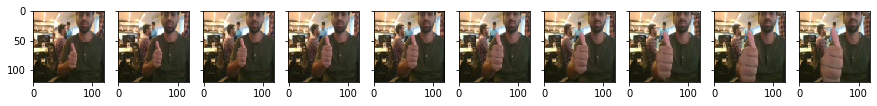

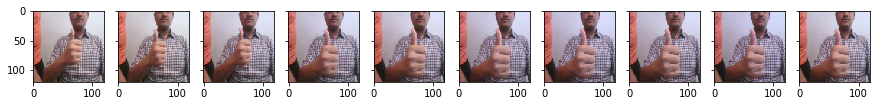

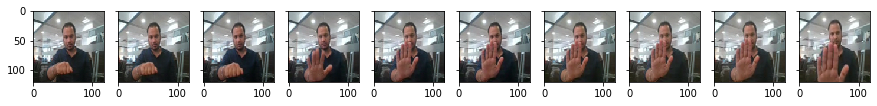

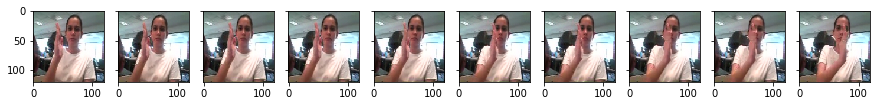

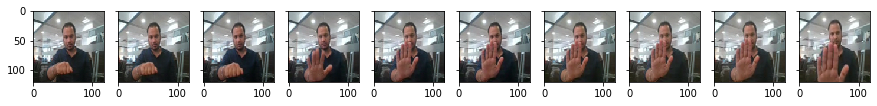

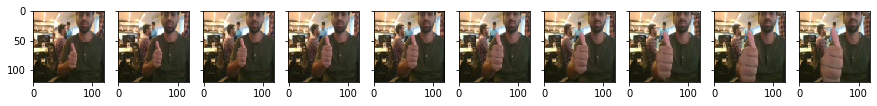

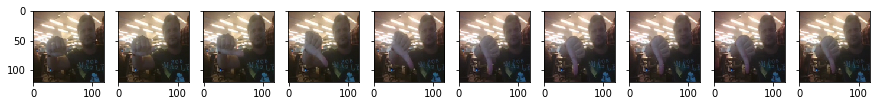

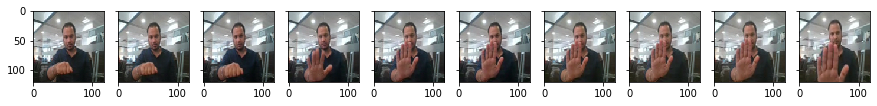

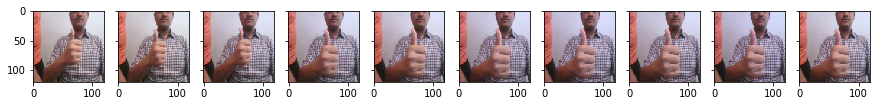

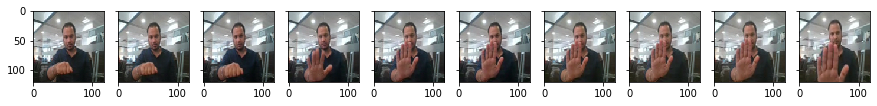

In [6]:
train_path = 'Project_data/Project_data/train'
test_images_generator = generator(train_path, train_doc, batch_size, ablation_size=10)

test_images = []
counter = 0
for test_img in test_images_generator:
    plot_image(test_img[0][0])
    
    
    counter = counter + 1
    if counter is 10:
        break;

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
# curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
# num_train_sequences = len(train_doc)
# print('# training sequences =', num_train_sequences)
# num_val_sequences = len(val_doc)
# print('# validation sequences =', num_val_sequences)
# num_epochs = # choose the number of epochs
# print ('# epochs =', num_epochs)

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/Project_data/train'
val_path = 'Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
#Aditya

NUM_CLASSES = 5

# With Conv3D
input_shape = (len(range(0,frame_count,interval)),img_size,img_size,3)
model = Sequential()
model.add(Conv3D(32, kernel_size=(2, 3, 3),
                 activation='relu', padding='same',
                 input_shape=input_shape)) # input shape = (img_rows, img_cols, 1)

model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=(2, 3, 3),
                 activation='relu', padding='same'))

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(2, 3, 3),
                 activation='relu')) # input shape = (img_rows, img_cols, 1)

model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(2, 3, 3),
                 activation='relu', padding='same'))

model.add(Flatten())

model.add(Dense(NUM_CLASSES, activation='softmax'))

print (model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 10, 120, 120, 32)  1760      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 120, 120, 32)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 120, 120, 32)  18464     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 60, 60, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 4, 58, 58, 64)     36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 58, 58, 64)     0         
_______________________

In [9]:
# model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2),
#     activation='relu', padding='same'), input_shape=input_shape))
# model.add(TimeDistributed(Conv2D(32, (3,3),
#     kernel_initializer="he_normal", activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Conv2D(64, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(Conv2D(64, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Conv2D(128, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(Conv2D(128, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Conv2D(256, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(Conv2D(256, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Conv2D(512, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(Conv2D(512, (3,3),
#     padding='same', activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Flatten()))

# model.add(Dropout(0.5))
# model.add(LSTM(256, return_sequences=False, dropout=0.5))
# model.add(Dense(NUM_CLASSES, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
learning_rate = 0.01
optimiser = optimizers.sgd(lr=learning_rate,clipvalue=1.0) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 10, 120, 120, 32)  1760      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 120, 120, 32)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 120, 120, 32)  18464     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 60, 60, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 4, 58, 58, 64)     36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 58, 58, 64)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 4, 58, 58, 64)     73792     
________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)# write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
# # Try ablation

# train_generator = generator(train_path, train_doc, batch_size, ablation_size=100)
# val_generator = generator(val_path, val_doc, batch_size)

# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [14]:
# Ablation shows good improvement. Lets run for entire train data

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Source path =  Project_data/Project_data/val ; batch size = 5
Source path =  Project_data/Project_data/train Epoch 1/50; batch size = 5



C:\Users\adi00\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\adi00\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


122/133 [==========================>...] - ETA: 12s - loss: 1.8386 - categorical_accuracy: 0.2230

C:\Users\adi00\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\adi00\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 160s 1s/step - loss: 1.8168 - categorical_accuracy: 0.2241 - val_loss: 1.5777 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2020-12-1915_30_10.541762/model-00001-1.81767-0.22474-1.57772-0.28000.h5
Epoch 2/50
133/133 [==============================] - 146s 1s/step - loss: 1.4636 - categorical_accuracy: 0.4025 - val_loss: 1.3009 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2020-12-1915_30_10.541762/model-00002-1.46395-0.40271-1.30094-0.60000.h5
Epoch 3/50
133/133 [==============================] - 147s 1s/step - loss: 1.0596 - categorical_accuracy: 0.6095 - val_loss: 0.9668 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2020-12-1915_30_10.541762/model-00003-1.05954-0.60935-0.96683-0.65000.h5
Epoch 4/50
133/133 [==============================] - 146s 1s/step - loss: 0.7416 - categorical_accuracy: 0.7363 - val_loss: 1.2192 - val_categorical_accuracy: 0.4700



KeyboardInterrupt: 